In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from path import Path as p

In [3]:
PATH = "../../../data/"
PATH2 = "../../../data/Flicker8k_Dataset/"
sz=224
bs = 64
n = 1000 # Number of dogs and cats to train model on
# imbalanced classes
CATDOG = 0 # Dummy class variables
NOTCATDOG = 1 # Not Cat or Not Dog

In [4]:
def get_names(filelist, suffix):
    return [suffix + f.name for f in filelist]

In [5]:
train_cats = get_names(p(PATH + "dogscats/train/cats/").files(), "dogscats/train/cats/")
train_dogs = get_names(p(PATH + "dogscats/train/dogs/").files(), "dogscats/train/dogs/")
valid_cats = get_names(p(PATH + "dogscats/valid/cats/").files(), "dogscats/valid/cats/")
valid_dogs = get_names(p(PATH + "dogscats/valid/dogs/").files(), "dogscats/valid/dogs/")
flickr = get_names(p(PATH2).files(), str(p(p(PATH2).abspath()).name) + "/")
print(len(train_cats))
print(len(train_dogs))
print(len(valid_cats))
print(len(valid_dogs))
print(len(flickr))

11500
11500
1000
1000
8091


In [6]:
def prep(train, valid):
    p(PATH + "/tmp/").rmtree_p() # remove cached training data
    animals = list(np.random.choice(train, n, False)) + list(valid)
    notanimals = list(np.random.choice(flickr, n + len(valid), False))
    fn = animals + notanimals
    yy = np.array([CATDOG]*len(animals) + [NOTCATDOG]*len(notanimals))
    cs = list(set(yy))
    v_cat_dog_idx = range(n, n + len(valid))
    v_not_idx = range(len(animals) + n, len(fn))
    vi = list(v_cat_dog_idx) + list(v_not_idx)
    return (fn, yy, cs, vi)

# fn or fnames: file names
# yy or y: numpy array which contains target labels ordered by filenames.
# cs or classes: a list of all labels/classifications, [0, 1]
# vi or val_idxs: index of images to be used for validation.

In [7]:
fnames, y, classes, val_idxs = prep(train_cats, valid_cats)

In [8]:
# Let's set up our model using the pretrained Resnet34 Imagenet model
arch=resnet34
data = ImageClassifierData.from_names_and_array(PATH, fnames, y, classes, \
                                                val_idxs, bs=bs, \
                                                tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.45it/s]


In [9]:
# Use a learning rate of 0.01 and train for 5 epochs
lr = 0.01
epochs = 5
learn.fit(lr, epochs)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.144633   0.029833   0.9905    
    1      0.072172   0.017825   0.9955                                                                                
    2      0.042604   0.016514   0.9955                                                                                
    3      0.030456   0.016861   0.9945                                                                                
    4      0.023329   0.016803   0.995                                                                                 



[array([0.0168]), 0.995]

In [10]:
# Create our prediction function
def predict(learner, pred_files, tfs = tfms_from_model(arch, sz)):
    orig_precompute = learner.precompute
    learner.precompute = False
    trn_tfms, val_tfms = tfs
    ds = FilesIndexArrayDataset(list(pred_files), np.zeros(len(pred_files)), val_tfms, PATH)
    dl = DataLoader(ds)
    log_preds = learner.predict_dl(dl)
    preds = np.exp(log_preds)
    results = np.argmax(preds, axis=1)
    learner.precompute = orig_precompute
    return results

In [11]:
# Now try to predict on dogs
pred_dogs = predict(learn, valid_dogs)
print(sum(pred_dogs))

924


In [12]:
fnames, y, classes, val_idxs = prep(train_dogs, valid_dogs)

In [13]:
arch=resnet34
data = ImageClassifierData.from_names_and_array(PATH, fnames, y, classes, \
                                                val_idxs, bs=bs, \
                                                tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:19<00:00,  1.66it/s]


In [14]:
# Use a learning rate of 0.01 and train for 5 epochs
lr = 0.01
epochs = 5
learn.fit(lr, epochs)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.273544   0.104241   0.961     
    1      0.178116   0.07542    0.9735                                                                                
    2      0.133336   0.066591   0.979                                                                                 
    3      0.105807   0.068254   0.9765                                                                                
    4      0.08784    0.069557   0.9735                                                                                



[array([0.06956]), 0.9735]

In [15]:
# Now try to predict on cats
pred_cats = predict(learn, valid_cats)
print(sum(pred_cats))

128


In [16]:
fnames, y, classes, val_idxs = prep(train_dogs, valid_dogs)

In [17]:
arch=resnet34
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on,\
                                        max_zoom=1.1)
data = ImageClassifierData.from_names_and_array(PATH, fnames, y, classes, \
                                                val_idxs, bs=bs, \
                                                tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:18<00:00,  1.69it/s]


In [18]:
learn.lr_find()

 59%|█████████████████████████████████████████▌                            | 19/32 [00:00<00:00, 41.06it/s, loss=0.727]


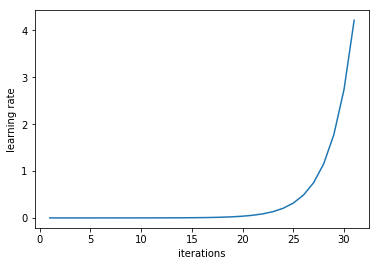

In [19]:
learn.sched.plot_lr()

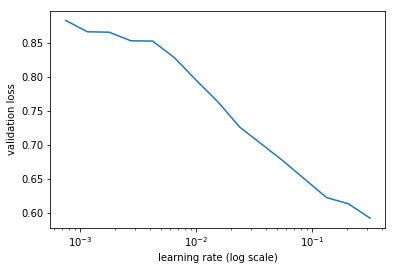

In [20]:
learn.sched.plot()

In [21]:
lr = 0.1

In [22]:
epochs = 5
learn.fit(lr, epochs)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.270769   0.148162   0.9635    
    1      0.197059   0.111687   0.9795                                                                                
    2      0.147369   0.133902   0.9735                                                                                
    3      0.104113   0.121386   0.98                                                                                  
    4      0.090849   0.117089   0.9785                                                                                



[array([0.11709]), 0.9785]

In [23]:
learn.precompute = False

In [24]:
learn.fit(lr, 3, cycle_len = 1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.11419    0.143086   0.97      
    1      0.083479   0.125067   0.9725                                                                                
    2      0.072018   0.092015   0.9775                                                                                



[array([0.09201]), 0.9775]

In [26]:
learn.unfreeze()

In [27]:
learn.lr_find()

 69%|████████████████████████████████████████████████▏                     | 22/32 [00:43<00:19,  1.98s/it, loss=0.181]

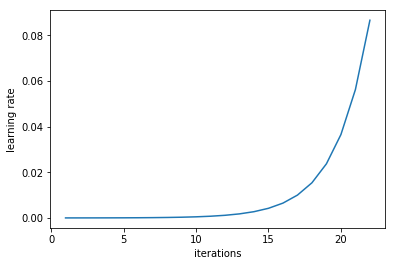

In [28]:
learn.sched.plot_lr()

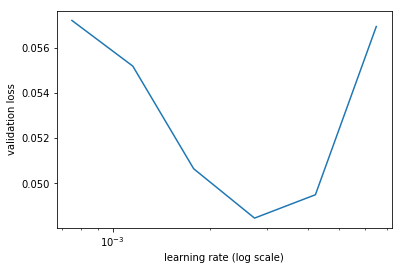

In [29]:
learn.sched.plot()

In [30]:
lr = np.array([1e-5, 1e-4, 1e-3])

In [31]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.07434    0.11083    0.973     
    1      0.077788   0.113765   0.9715                                                                                
    2      0.1239     0.142253   0.969                                                                                 
    3      0.09598    0.116168   0.9715                                                                                
    4      0.075607   0.120482   0.9705                                                                                
    5      0.063133   0.105633   0.9735                                                                                
    6      0.057191   0.112212   0.9715                                                                                


[array([0.11221]), 0.9715]

In [32]:
# Now try to predict on cats
pred_cats = predict(learn, valid_cats)
print(sum(pred_cats))

349
